# A notebook describing the basics of CCD data reduction, including some guidance for keeping track of uncertainties along the way. 

Two cautions before we proceed: 

(1) FITS files consider the first pixel to be '1' whereas python considers the first pixel to be '0'. 

(2) FITS header coordinates are given as (x,y) but python indexes images as (y,x). 

In [37]:
# start by importing the necessities 
import numpy as np 
from astropy.io import fits 
from matplotlib import pyplot as plt 

import glob
import os

# Bias 

A bias frame is an image taken with zero exposure time. Counts in a bias frame are never zero even though this image is taken with no light hitting the CCD and no integration time. CCDs add a voltage offset to all pixels so that when the accumlated signal in each pixel is converted to a number, the number is always positive. Ideally this number would be constant pixel-to-pixel and night-to-night. In practice, there are slight variations between pixels and over time. 

To correct for this, we take a set of bias frames each night we observe. In addition, data from McDonald have an 'overscan' section. This is a strip of pixels along the right edge that are not exposed to light and therefore track variations in the bias (and dark current) during the night. (more information about removing the overscan region is provided as part of Lab 2)

To start, read in the bias frames. 

In [2]:
biases = glob.glob('/Users/mr82/teaching/data_for_ASTR230/biases_20240214/*.fits')
biases

['/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0004.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0008.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0009.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0005.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0075.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0080.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0079.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0002.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0003.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0078.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0081.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0074.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0077.fits',
 '/Users/mr82/teaching/data_for_ASTR230/biases_20240214/obj0082.fits',
 '/Use

Look at the header information for one of the files. Notice that the exposure time 'EXPTIME' is 0.0 and the 'IMGTYPE' is 'zero.' 

In [3]:
fits.getheader(biases[0])

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1056 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
DATE    = '2024-02-15T01:42:35' / Date FITS file was generated                  
IRAF-TLM= '2024-02-15T01:41:42' / Time of last modification                     
OBJECT  = 'Bias    '           / Name of the object observed                    
OBSERVAT= 'MCDONALD         

Let's take a look at one of the bias images to see what it looks like. 

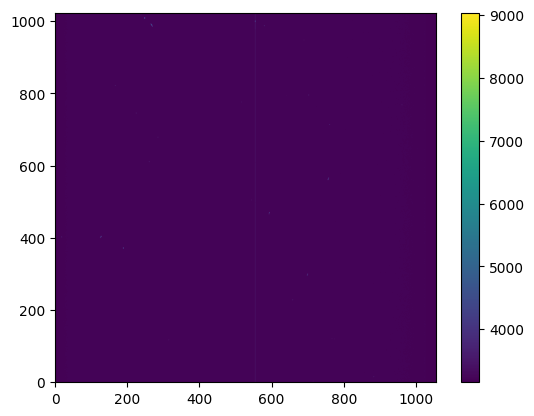

In [4]:
bias1 = fits.getdata(biases[0])
plt.imshow(bias1, origin='lower')
plt.colorbar()

Note that we use the keyword *origin='lower'* to orient the image the same way that it appears when it is opened in ds9. The default scaling doesn't tell us much. Let's look at the median and standard deviation to estimate more useful upper and lower bounds for the image scaling. 

In [5]:
med_bias1 = np.median(bias1)
med_bias1

3212.0

In [6]:
std_bias1 = np.std(bias1)
std_bias1

22.05385730618298

Use the median and the standard deviation to set the minimum and maximum values for the color scaling. 

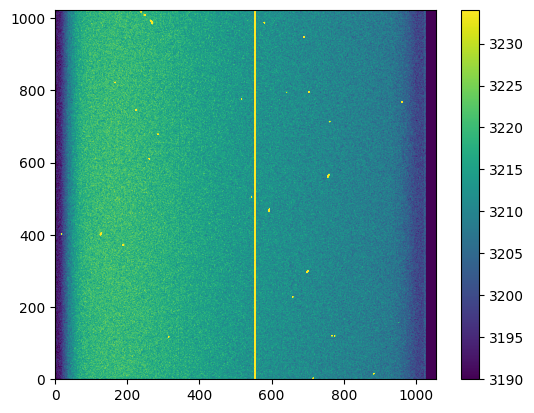

In [7]:
plt.imshow(bias1, origin='lower', vmin=(med_bias1-std_bias1), vmax=(med_bias1+std_bias1))
plt.colorbar()

Notice the variation in pixel values. If you look at a different bias image, does it look the same? The dark column on the right of the image is the overscan region. 

Now, let's read in all the bias frames and combine them into a master bias frame that we will use to subtract the bias from our data. 

In [38]:
bias_timestream = [fits.getdata(x) for x in biases]

Noise is random which means that it will be positive roughly as often as it will be negative. By averaging together multiple frames, we can average out some of the noise to get a more accurate measure of the bias. 

In [39]:
# average of the bias frames 
mean_bias = np.mean(bias_timestream, axis=0)
# median 
median_bias = np.median(bias_timestream, axis=0)

Which should you use - the mean or the median? 

If you are new to statistics, you may find 'Statistics by Jim' useful, especially posts on 

the central tendency (mean, median, mode): https://statisticsbyjim.com/basics/measures-central-tendency-mean-median-mode/

and

measures of variability (range, interquartile range, variance, standard deviation): https://statisticsbyjim.com/basics/variability-range-interquartile-variance-standard-deviation/

Display both the mean and the median bias frames. How do they compare?

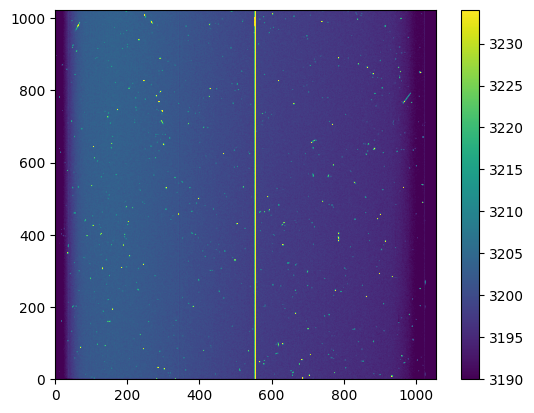

In [10]:
plt.imshow(mean_bias, origin='lower', vmin=(med_bias1-std_bias1), vmax=(med_bias1+std_bias1))
plt.colorbar()

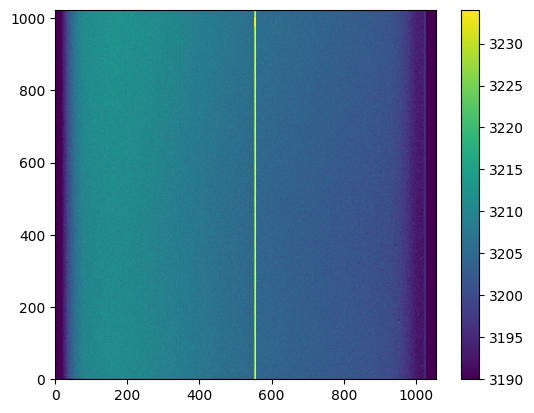

In [11]:
plt.imshow(median_bias, origin='lower', vmin=(med_bias1-std_bias1), vmax=(med_bias1+std_bias1))
plt.colorbar()

The mean amplifies the outliers, the median provides a more robust representation of the middle value. So we'll use the median. 

There is always some noise associated with reading out the detector - this is the readnoise and it will be in every frame. In a zero second exposure, the readnoise is the only source of noise. Therefore, we can estimate the readnoise by looking at the standard deviation of the bias frames. 

In [12]:
# get the standard deviation of the bias frames to estimate the read noise 
stddev_bias = np.std(bias_timestream, axis=0)
readnoise = np.median(stddev_bias)
readnoise

17.558932647016995

Our master bias frame has lower noise than an individual frame because we've taken the median of many frames, so the noise is lower by a factor $\sqrt{N_{\mathrm{frames}}}$.

In [13]:
mean_bias_noise = readnoise / np.sqrt(len(biases))
mean_bias_noise

3.743577018783938

You can also check the estimate of the readnoise that is reported in the header in the 'RDNOISE' key. 

In [40]:
fits.getheader(biases[0])['RDNOISE']

5.87

Try trimming the image and removing the overscan section (see Lab 2 for instructions). How does this change the estimated readnoise? 

Big files take a lot of computer memory. To limit how much data is kept in memory, we can delete variables that contain a lot of data once we're done using them:

In [41]:
del bias_timestream

# Flat

Pixels have an uneven response. Even for the same input signal, different pixels will record different counts. To quantify this, we take an image of a uniformly illuminated surface. This can be either a screen in the dome illuminated with a lamp or sometimes the twilight sky. If the detector response was perfect, every pixel would have the same number of counts. In reality, this will not be the case. A flatfield allows us to correct for these pixel-to-pixel variations. 

First, let's find the filenames for the flats. Then we'll read in and combine the individual exposures. 

In [36]:
Vflats = glob.glob('/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V*.fits')
Vflats

['/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0001.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0000.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0007.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0006.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0010.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0005.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0009.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0008.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0004.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0003.fits',
 '/Users/mr82/teaching/data_for_ASTR230/flats_feb2024/V_0002.fits']

In [16]:
Vflat_timestream = [fits.getdata(x)for x in Vflats]
mean_Vflat = np.mean(Vflat_timestream, axis=0)
median_Vflat = np.median(Vflat_timestream, axis=0)
del Vflat_timestream

This flatfield image still includes the bias signal so we subtract that from the flat field. 

In [17]:
bias_subtracted_Vflat = median_Vflat - median_bias

Next, we want to normalize the flat so its average value is ~1. This is so we can divide by the flatfield to remove pixel-to-pixel variations without reducing the number of counts in our science image. 

Here, we'll divide the flat by its mean so that the average value of the flat is ~1 everywhere. 

In [44]:
Vflat_mean = np.mean(bias_subtracted_Vflat)
normalized_mean_Vflat = bias_subtracted_Vflat / Vflat_mean

Check that the average of the flat image is indeed 1:

In [45]:
np.mean(normalized_mean_Vflat)

1.0000000000000004

The image of a flatfield should look pretty smooth. 

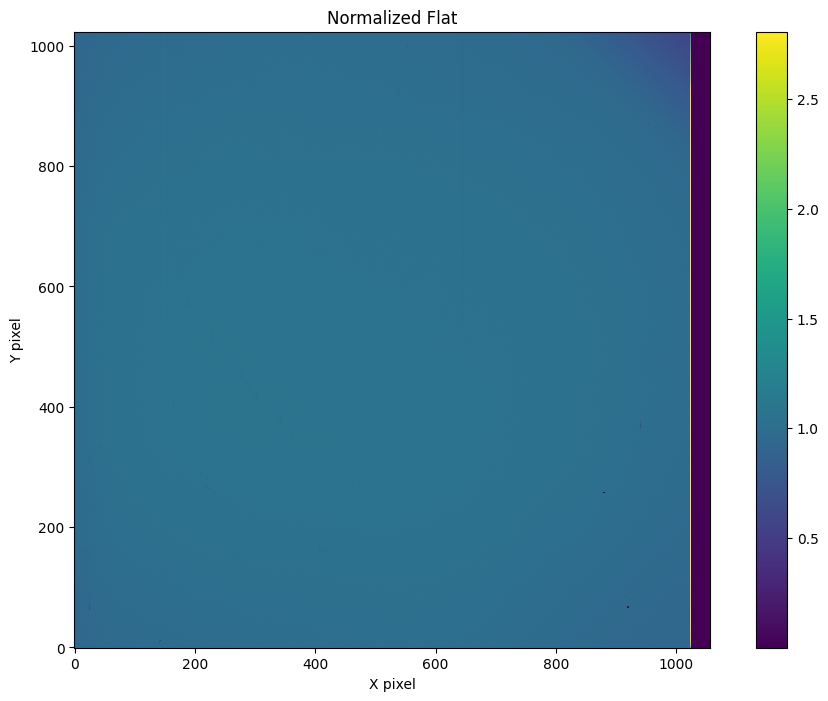

In [47]:
plt.figure(figsize=(12,8))

_=plt.imshow(normalized_mean_Vflat, origin='lower', interpolation='none')
_=plt.colorbar()
_=plt.title("Normalized Flat")
_=plt.xlabel("X pixel")
_=plt.ylabel("Y pixel")

However, if we adjust the scaling to look for small deviations from one, you can see some of the imperfections of the detector. Also notice there is a dark spot in the upper right hand corner. The filter wheel had some positioning issues on this observing run. 

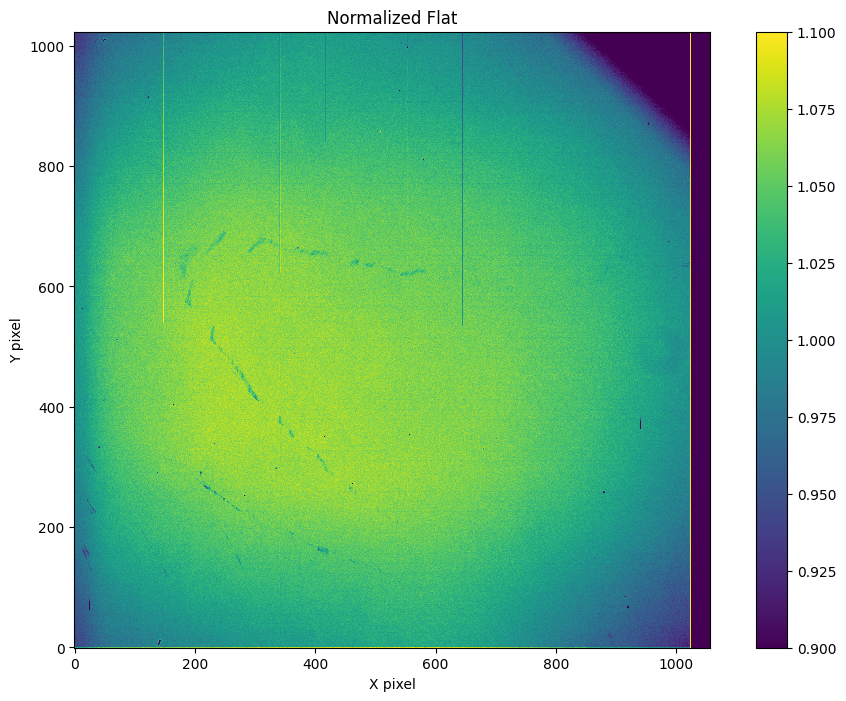

In [48]:
plt.figure(figsize=(12,8))

_=plt.imshow(normalized_mean_Vflat, origin='lower', interpolation='none', vmin=0.9,vmax=1.1)
_=plt.colorbar()
_=plt.title("Normalized Flat")
_=plt.xlabel("X pixel")
_=plt.ylabel("Y pixel")

### uncertainty in the flat

Just as with our science data, we are counting photons when we take a flat field image. To estimate the uncertainty in the flatfield image, we therefore need to account for the Poisson noise and the readnoise of the image. 

Remember that the Poisson noise is just the square root of the signal. We can measure this using our bias-subtracted flatfield image. 

In [22]:
flat_poisson_uncertainty = np.sqrt(bias_subtracted_Vflat)

Including the readnoise, we have a single-frame uncertainty of: 

In [23]:
flat_singleframe_uncertainty = np.sqrt(flat_poisson_uncertainty**2 + readnoise**2)

We took several frames and used the median to reduce the noise. The uncertainty in the combined flat image is lower than that in the individual frames by $\sqrt{N_{\mathrm{frames}}}$. 

We also propogate the uncertainty from the bias frame (since we subtracted it from the flatfield image) to find the total uncertainty of the flat field image. 

In [24]:
flat_total_uncertainty = np.sqrt((flat_singleframe_uncertainty/np.sqrt(len(Vflats)))**2 + mean_bias_noise**2)

We divided the flat image by the average to normalize the counts. The uncertainty on the flat is similarly reduced. 

Recall that when propagating uncertainties, for the equation $y=a \times x$, the associated uncertainty is $\delta_y = a \times \delta_x$


In [25]:
normalized_flat_uncertainty = flat_total_uncertainty / Vflat_mean

# Dark current

Dark current is an additional signal from the environment that builds up over time and varies with temperature. Dark frames are taken when the shutter is closed and no light is falling on the detector. The exposure time of the dark frames should be the same as the science images. 

The CCD on the McDonald 30" is cryocooled which significantly decreases the dark current. We usually skip this step for imaging at McDonald. 

None of the detectors on RUCO are cooled and the dark current can be quite significant. Be sure to take dark frames for any data obtained with RUCO. 

The procedure for processing darks is similar to making a master flat-field image. Read in the data and take the median. If you have many dark frames, you can measure the uncertainty in the dark current from the standard deviation. 

**Be sure all your dark frames have the same exposure time as each other and your science data!** 

Since we don't have dark frames for the McDonald data, these steps have been commented out. 

In [26]:
'''
darks = glob.glob('/Users/mr82/teaching/data_for_ASTR230/darks/*.fits')
darks
'''

"\ndarks = glob.glob('/Users/mr82/teaching/data_for_ASTR230/darks/*.fits')\ndarks\n"

In [27]:
'''
darks_frms = [fits.getdata(x) for x in darks]
average_dark = np.mean(darks_frms, axis=0)
median_dark = np.median(darks_frms, axis=0)
stddev_dark = np.std(darks_frms, axis=0)
del darks_frms
'''

"\ndarks_frms = [fits.getdata(x)*fits.getheader(x)['GAIN'] for x in darks]\naverage_dark = np.mean(darks_frms, axis=0)\nmedian_dark = np.median(darks_frms, axis=0)\nstddev_dark = np.std(darks_frms, axis=0)\ndel darks_frms\n"

In [28]:
# uncertainty_on_mean_dark = stddev_dark / np.sqrt(len(darks))

# Target images

In [29]:
ims = glob.glob('/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj00??.fits')
ims

['/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0053.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0049.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0048.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0052.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0055.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0054.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0058.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0057.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0056.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0047.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0051.fits',
 '/Users/mr82/teaching/data_for_ASTR230/ngc2264/obj0050.fits']

Let's start with one image.

In [30]:
sci_dat = fits.open(ims[0])
sci_im = sci_dat[0].data
sci_hdr = sci_dat[0].header

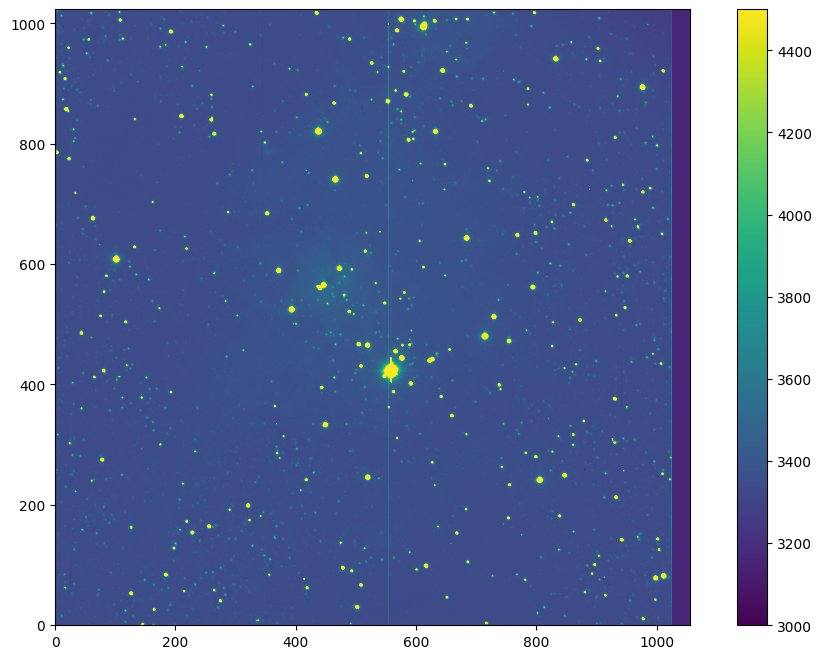

In [55]:
plt.figure(figsize=(12,8))

plt.imshow(sci_im, origin='lower', vmin=3000, vmax=4500)
plt.colorbar()

Make a histogram to see what fraction of pixels have certain values. Notice that there is a lot of sky between stars - there will be a lot of pixels with low values. The detector has a maximum value of counts it can collect - this is the saturation value. If we have any bright stars in the field that saturated, we'll see a pileup of counts at the bright end too. 

(array([1.075827e+06, 2.357000e+03, 8.440000e+02, 4.360000e+02,
        2.890000e+02, 1.890000e+02, 1.580000e+02, 1.110000e+02,
        8.100000e+01, 7.500000e+01, 6.500000e+01, 5.200000e+01,
        5.000000e+01, 4.800000e+01, 4.500000e+01, 3.500000e+01,
        2.900000e+01, 2.600000e+01, 2.300000e+01, 1.600000e+01,
        1.400000e+01, 2.800000e+01, 1.600000e+01, 1.800000e+01,
        1.100000e+01, 1.300000e+01, 1.000000e+01, 1.600000e+01,
        1.400000e+01, 6.000000e+00, 1.100000e+01, 8.000000e+00,
        8.000000e+00, 7.000000e+00, 1.000000e+01, 8.000000e+00,
        5.000000e+00, 1.000000e+01, 1.000000e+01, 6.000000e+00,
        8.000000e+00, 7.000000e+00, 6.000000e+00, 6.000000e+00,
        8.000000e+00, 1.500000e+01, 1.030000e+02, 6.800000e+01,
        4.900000e+01, 8.900000e+01]),
 array([ 3155.  ,  4290.56,  5426.12,  6561.68,  7697.24,  8832.8 ,
         9968.36, 11103.92, 12239.48, 13375.04, 14510.6 , 15646.16,
        16781.72, 17917.28, 19052.84, 20188.4 , 21323.96, 

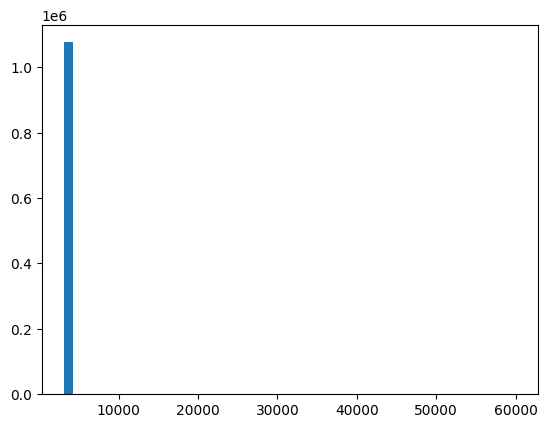

In [51]:
plt.hist(sci_im.ravel(), bins=50)

Notice that almost all the pixels in the image have relatively low counts making it impossible to see the bars at higher counts in this case. To make it easier to see the dynamic range, plot the histogram in log. 

(array([1.075827e+06, 2.357000e+03, 8.440000e+02, 4.360000e+02,
        2.890000e+02, 1.890000e+02, 1.580000e+02, 1.110000e+02,
        8.100000e+01, 7.500000e+01, 6.500000e+01, 5.200000e+01,
        5.000000e+01, 4.800000e+01, 4.500000e+01, 3.500000e+01,
        2.900000e+01, 2.600000e+01, 2.300000e+01, 1.600000e+01,
        1.400000e+01, 2.800000e+01, 1.600000e+01, 1.800000e+01,
        1.100000e+01, 1.300000e+01, 1.000000e+01, 1.600000e+01,
        1.400000e+01, 6.000000e+00, 1.100000e+01, 8.000000e+00,
        8.000000e+00, 7.000000e+00, 1.000000e+01, 8.000000e+00,
        5.000000e+00, 1.000000e+01, 1.000000e+01, 6.000000e+00,
        8.000000e+00, 7.000000e+00, 6.000000e+00, 6.000000e+00,
        8.000000e+00, 1.500000e+01, 1.030000e+02, 6.800000e+01,
        4.900000e+01, 8.900000e+01]),
 array([ 3155.  ,  4290.56,  5426.12,  6561.68,  7697.24,  8832.8 ,
         9968.36, 11103.92, 12239.48, 13375.04, 14510.6 , 15646.16,
        16781.72, 17917.28, 19052.84, 20188.4 , 21323.96, 

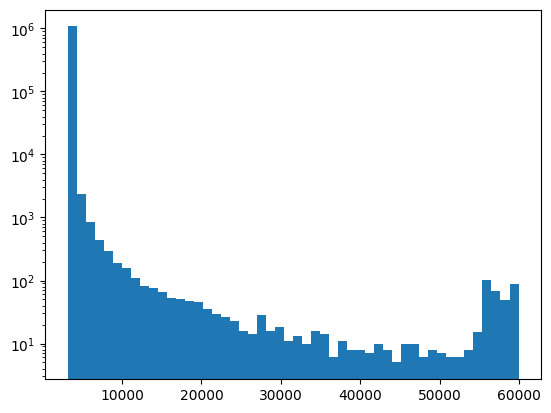

In [52]:
plt.hist(sci_im.ravel(), bins=50, log=True)

Notice that there is a bump at the high end. This suggests that some pixels in our image are saturated. Indeed, if you look at the image you can see vertical lines coming from a bright star in the middle of the cluster. 

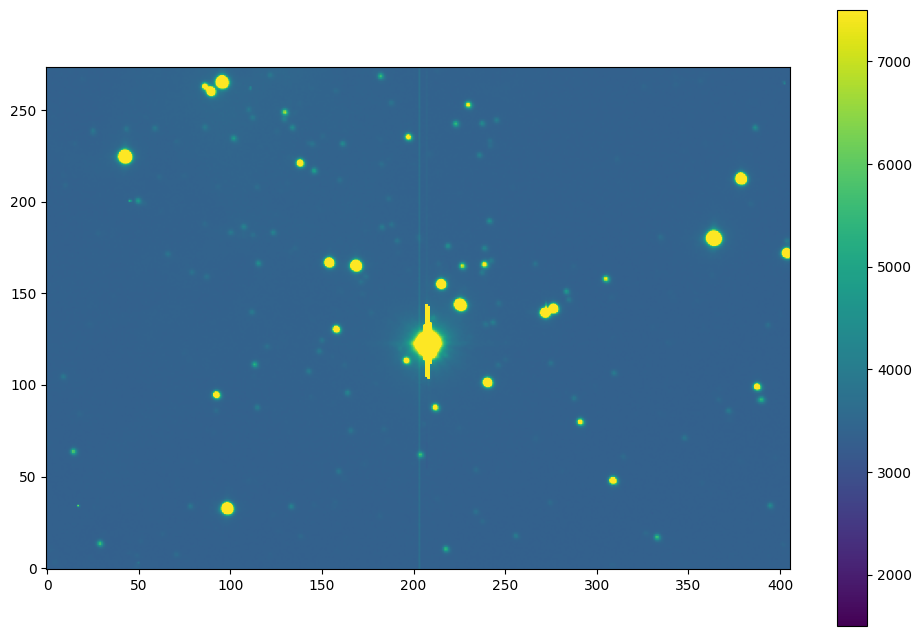

In [34]:
plt.figure(figsize=(12,8))
plt.imshow(sci_im[300:-450,350:-300], origin='lower', vmin=1500, vmax=7500)
plt.colorbar()

To start processing the image, subtract the bias and divide the image by the flatfield. 

In [35]:
sci_im_b = (sci_im - median_bias)
sci_im_f = sci_im_b / normalized_mean_Vflat

Don't forget to propogate the uncertainties using the rules for addition (e.g., $z = x + y$):  

$\sigma_{z}^2 = \sigma_{x}^2 + \sigma_{y}^2$

and multiplication (e.g., $z = x/y$): 

$(\frac{\sigma_{z}}{z})^2 = (\frac{\sigma_{x}}{x})^2 + (\frac{\sigma_{y}}{y})^2$